Simulated Patient 

In [2]:
import pandas as pd
import numpy as np
import os

from textwrap import wrap
from matplotlib import pyplot as plt
from stable_baselines3 import PPO, A2C, DQN
from sklearn.ensemble import RandomForestClassifier
from environment.fogg_behavioural_model import Patient 
from multiprocessing import Pool

In [3]:
updated_every_day = 24 
week= 7 * updated_every_day

In [4]:
eight_weeks = week * 8
five_weeks = week * 5

In [5]:
#basic stable condition
condition = 'stable'
habituation=False
time_preference_update_step= 9999999999999999 #very high e.g. 9999999999 to make it outside of the intervention time...effectively no preference shift

#Other options:
# condition = 'habituated'
# habituation=True
# time_preference_update_step= 9999999999999999 

# condition = 'changed_preference'
# habituation=False
# time_preference_update_step= five_weeks

# condition = 'habituated_changed_preference'
# habituation=True
# time_preference_update_step= five_weeks

In [6]:
# 500 runs in the paper
runs = 500

In [7]:
results_directory = 'results'
if not os.path.exists(results_directory):
    os.makedirs(results_directory)

In [8]:
patients_answers = [
    ["no", "no", "no", "no", "no"],
    ["no", "no", "no", "yes", "yes"],
    ["yes", "yes", "neutral", "yes", "yes"],
    ["neutral", "yes", "yes", "neutral", "neutral"],
]

In [8]:
def run_experiment(method, runs, name, condition, patient_answers, patient_id, show_notif_info=True):
    rr_random_list = []
    not_random_list = []
    sleep_list = []
    positive_list = []
    performed = 0
    for run in range(0, runs):

        env1 = Patient(behaviour_threshold=20,habituation=habituation, time_preference_update_step=time_preference_update_step,
                      patient_answers=patient_answers)
        env1 = method(env1)
        if sum(env1.num_performed):
            performed += 1
        df = pd.DataFrame()
        df['responce_ratio'] = env1.rr
        df['activity performed'] = env1.num_performed
        df['notifications'] = env1.num_notified
        df['sleep'] = env1.h_slept
        df['positive'] = env1.h_positive
        df['non_stationary'] = env1.h_nonstationary
        
        df.to_csv("{0}/patient{1}_{2}_{3}_run{4}.csv".format(results_directory, patient_id, condition, name, run))
        rr_random_list.append(df.responce_ratio)
        not_random_list.append(df.notifications)
        sleep_list.append(df.sleep)
        positive_list.append(df.positive)

    print("This figures include runs in which no prompt resulted in the activity being performed")
    print("{0} out of {1} resulted in activity being performed ".format(performed, runs))
    fig = plt.figure( figsize=(8, 5))
    plt.plot(np.nanmean(np.array(sleep_list), axis=0), label='Hours slept', color ='r')
    plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
    plt.ylabel('Hours ')
    plt.xlabel('Intevention Days')
    plt.legend()
    plt.show()
    
    if show_notif_info:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
        ax1.plot(np.nanmean(rr_random_list, axis=0), label='responce rate', color ='r')
        ax2.plot(np.nanmean(not_random_list, axis=0), label='num notified')
        ax2.set_xlabel('Intervention Days')
        ax2.set_ylabel('No. notifications')
        ax1.set_ylabel('Responce ratio')
        plt.show()
        
    return sleep_list, positive_list, rr_random_list, not_random_list

In [9]:
def one_run(run_num, method, patient_answers, name, performed_dict):
    performed_dict[run_num] = 0
    env1 = Patient(behaviour_threshold=20,habituation=habituation, time_preference_update_step=time_preference_update_step,
                      patient_answers=patient_answers)
    env1 = method(env1)
    if sum(env1.num_performed):
        performed_dict[run_num] = 1
    df = pd.DataFrame()
    df['responce_ratio'] = env1.rr
    df['activity performed'] = env1.num_performed
    df['notifications'] = env1.num_notified
    df['sleep'] = env1.h_slept
    df['positive'] = env1.h_positive
    df['non_stationary'] = env1.h_nonstationary
    
    df.to_csv("{0}/patient{1}_{2}_{3}_run{4}.csv".format(results_directory, patient_id, condition, name, run_num))

def run_experiment(method, runs, name, condition, patient_answers, patient_id, show_notif_info=True):
    rr_random_list = []
    not_random_list = []
    sleep_list = []
    positive_list = []
    performed = 0
    
    manager = multiprocessing.Manager()
    performed_dict = manager.dict()
    jobs = []
    for i in range(0, runs):
        p = multiprocessing.Process(target=one_run, args=(i, method, patient_answers, name, performed_dict))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
        
    performed = sum(performed_dict.values())
    
    for run in range(0, runs):
        df = pd.read_csv("{0}/patient{1}_{2}_{3}_run{4}.csv".format(results_directory, patient_id, condition, name, run))
        rr_random_list.append(df.responce_ratio)
        not_random_list.append(df.notifications)
        sleep_list.append(df.sleep)
        positive_list.append(df.positive)
        
    print("This figures include runs in which no prompt resulted in the activity being performed")
    print("{0} out of {1} resulted in activity being performed ".format(performed, runs))
    fig = plt.figure( figsize=(8, 5))
    plt.plot(np.nanmean(np.array(sleep_list), axis=0), label='Hours slept', color ='r')
    plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
    plt.ylabel('Hours ')
    plt.xlabel('Intevention Days')
    plt.legend()
    plt.show()
    
    if show_notif_info:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
        ax1.plot(np.nanmean(rr_random_list, axis=0), label='responce rate', color ='r')
        ax2.plot(np.nanmean(not_random_list, axis=0), label='num notified')
        ax2.set_xlabel('Intervention Days')
        ax2.set_ylabel('No. notifications')
        ax1.set_ylabel('Responce ratio')
        plt.show()
        
    return sleep_list, positive_list, rr_random_list, not_random_list

In [9]:
def one_run(run_num, method, patient_answers, name):
    env1 = Patient(behaviour_threshold=20,habituation=habituation, time_preference_update_step=time_preference_update_step,
                      patient_answers=patient_answers)
    env1 = method(env1)
    df = pd.DataFrame()
    df['responce_ratio'] = env1.rr
    df['activity performed'] = env1.num_performed
    df['notifications'] = env1.num_notified
    df['sleep'] = env1.h_slept
    df['positive'] = env1.h_positive
    df['non_stationary'] = env1.h_nonstationary
    
    df.to_csv("{0}/patient{1}_{2}_{3}_run{4}.csv".format(results_directory, patient_id, condition, name, run_num))
    
    return 1 if sum(env1.num_performed) else 0
        

def run_experiment(method, runs, name, condition, patient_answers, patient_id, show_notif_info=True):
    rr_random_list = []
    not_random_list = []
    sleep_list = []
    positive_list = []
    performed = 0
    with Pool(processes=15) as pool:
        args = [(i, method, patient_answers, name) for i in range(0, runs)]
        performed_list = pool.starmap(one_run, args)
        performed = sum(performed_list)
    
    for run in range(0, runs):
        df = pd.read_csv("{0}/patient{1}_{2}_{3}_run{4}.csv".format(results_directory, patient_id, condition, name, run))
        rr_random_list.append(df.responce_ratio)
        not_random_list.append(df.notifications)
        sleep_list.append(df.sleep)
        positive_list.append(df.positive)
        
    print("This figures include runs in which no prompt resulted in the activity being performed")
    print("{0} out of {1} resulted in activity being performed ".format(performed, runs))
    fig = plt.figure( figsize=(8, 5))
    plt.plot(np.nanmean(np.array(sleep_list), axis=0), label='Hours slept', color ='r')
    plt.plot(np.mean(positive_list, axis=0), label='Hours in positive mood')
    plt.ylabel('Hours ')
    plt.xlabel('Intevention Days')
    plt.legend()
    plt.show()
    
    if show_notif_info:
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
        ax1.plot(np.nanmean(rr_random_list, axis=0), label='responce rate', color ='r')
        ax2.plot(np.nanmean(not_random_list, axis=0), label='num notified')
        ax2.set_xlabel('Intervention Days')
        ax2.set_ylabel('No. notifications')
        ax1.set_ylabel('Responce ratio')
        plt.show()
        
    return sleep_list, positive_list, rr_random_list, not_random_list

In [10]:
def always_notify(env1, intervention_legth=eight_weeks):
    
    action = 0
    for i in  range(intervention_legth):
        
        observation, reward, done, info = env1.step(action)
        if observation[9] == 3 or observation[3] ==1:
            action = 0
        else:
            action = 1
            
    return env1

# Intervention

## Random 
Randomly sample during the day skip the nights

In [11]:
def random_notification(env1, intervention_legth=eight_weeks):
    
    action = 0
    for i in  range(intervention_legth):
        
        observation, reward, done, info = env1.step(action)
        if observation[9] ==3:
            action = 0
        else:
            action = env1.action_space.sample()
            
    return env1

Patient 1
This figures include runs in which no prompt resulted in the activity being performed
403 out of 500 resulted in activity being performed 


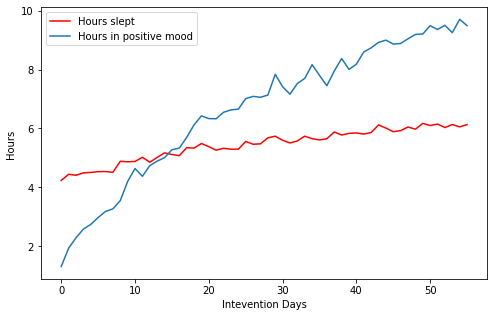

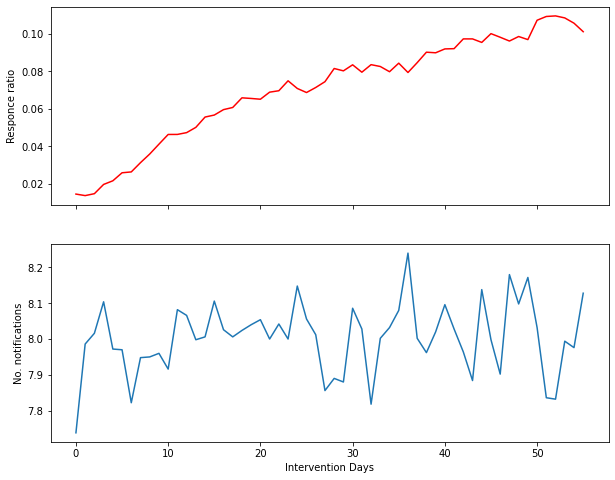

Patient 2
This figures include runs in which no prompt resulted in the activity being performed
388 out of 500 resulted in activity being performed 


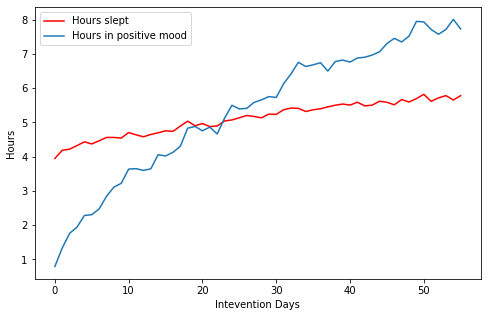

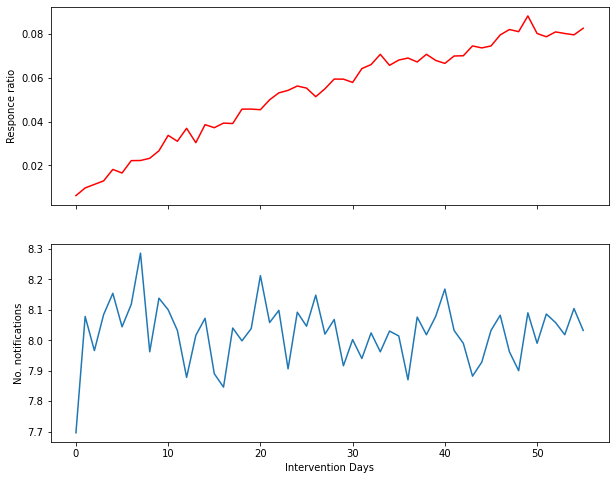

Patient 3
This figures include runs in which no prompt resulted in the activity being performed
400 out of 500 resulted in activity being performed 


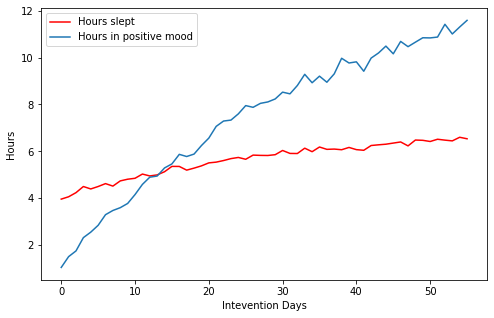

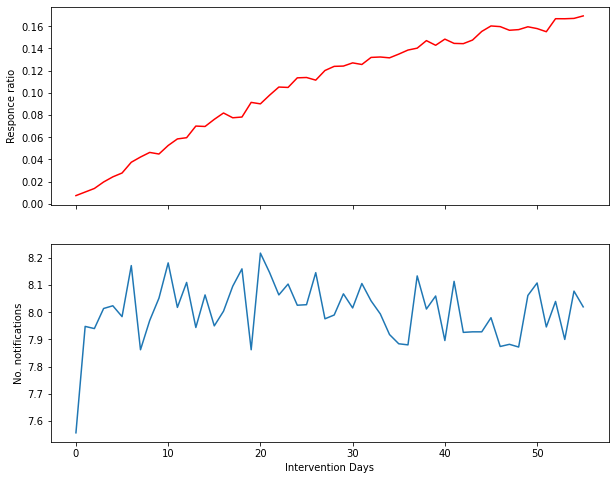

Patient 4
This figures include runs in which no prompt resulted in the activity being performed
392 out of 500 resulted in activity being performed 


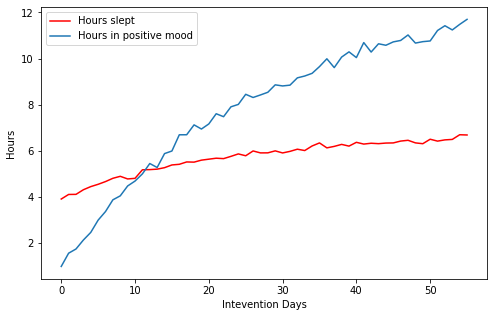

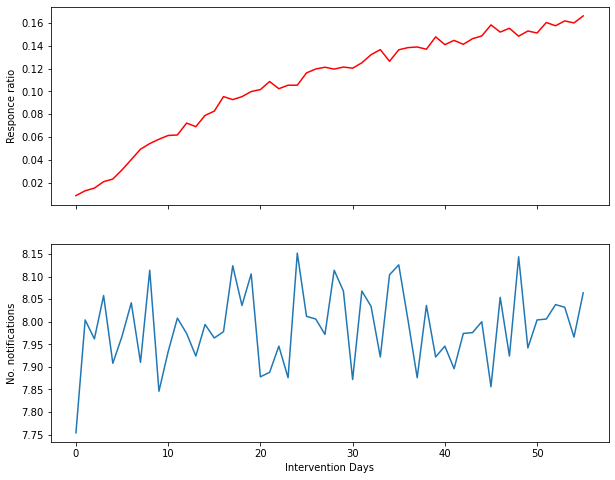

In [12]:
for i, answers in enumerate(patients_answers):
    patient_id = i+1
    print(f"Patient {patient_id}")
    _ = run_experiment(random_notification, runs, 'random', condition, answers, patient_id)

## Supervised adaptive model

In [13]:
def rf_adaptive_after_three_weeks(env1):
    
    three_weeks = 24 * 7 *3
    env1 = always_notify(env1, intervention_legth=three_weeks)
    clf = RandomForestClassifier(class_weight='balanced')
    clf.fit(env1.observation_list, env1.activity_performed)
    remaining_time = eight_weeks - three_weeks
    observation = env1._get_current_state()
    samples = len(env1.observation_list)
    for i in range(remaining_time):
        # applying supervised model
        action = clf.predict(np.array([observation]))[0]
        observation, reward, done, info = env1.step(action)
        if len(env1.observation_list)> samples: # retrain when new samples are provided
            clf = RandomForestClassifier(class_weight='balanced')
            clf.fit(env1.observation_list, env1.activity_performed)
            samples = len(env1.observation_list)
            
        
    return env1

Patient 1
This figures include runs in which no prompt resulted in the activity being performed
231 out of 500 resulted in activity being performed 


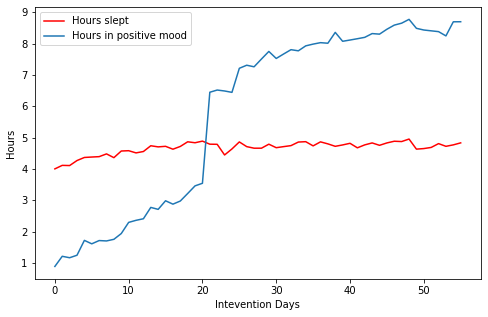

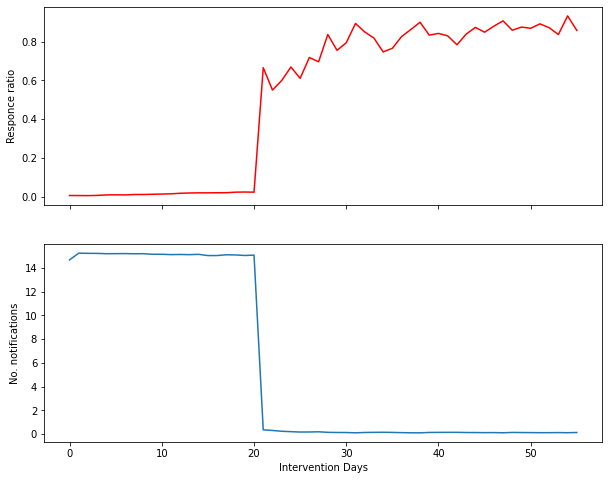

Patient 2
This figures include runs in which no prompt resulted in the activity being performed
222 out of 500 resulted in activity being performed 


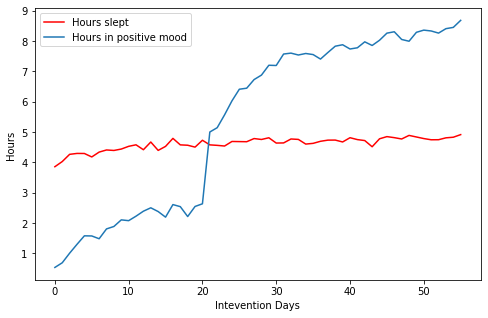

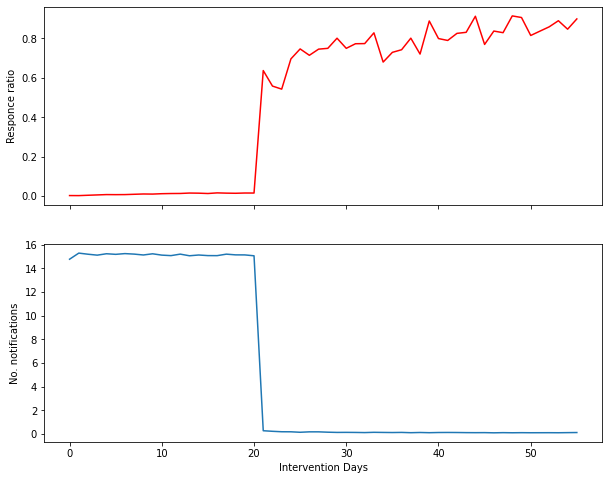

Patient 3
This figures include runs in which no prompt resulted in the activity being performed
243 out of 500 resulted in activity being performed 


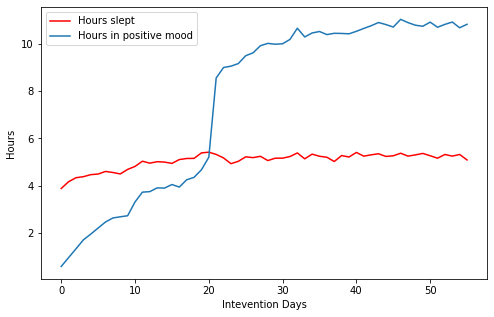

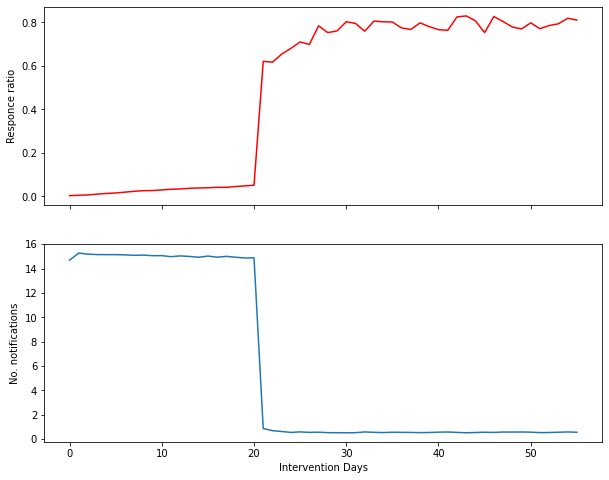

Patient 4
This figures include runs in which no prompt resulted in the activity being performed
226 out of 500 resulted in activity being performed 


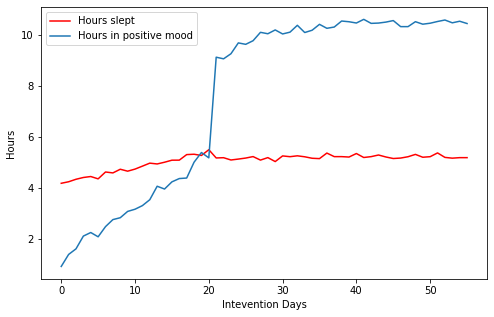

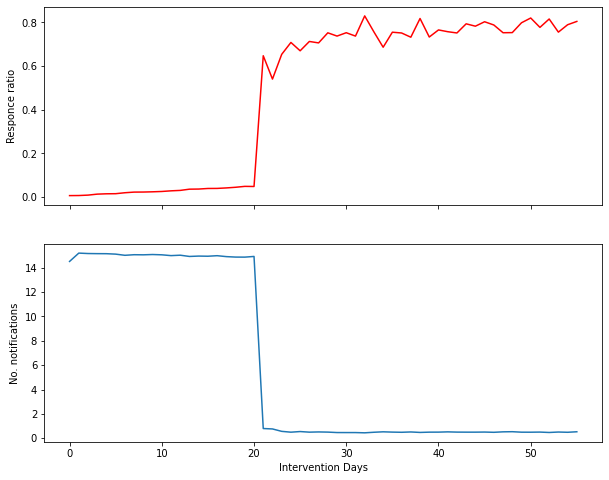

CPU times: user 3.79 s, sys: 540 ms, total: 4.33 s
Wall time: 29min 17s


In [14]:
%%time 
for i, answers in enumerate(patients_answers):
    patient_id = i+1
    print(f"Patient {patient_id}")
    _ = run_experiment(rf_adaptive_after_three_weeks, runs, 'rf_adaptive', condition, answers, patient_id)

## Deep Q Network

In [15]:
def dqn(env1):
    model = DQN("MlpPolicy", env1, verbose=0, learning_starts=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

Patient 1
This figures include runs in which no prompt resulted in the activity being performed
337 out of 500 resulted in activity being performed 


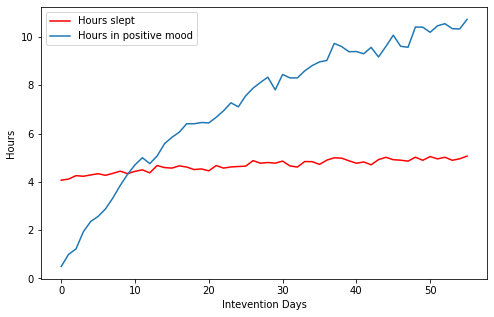

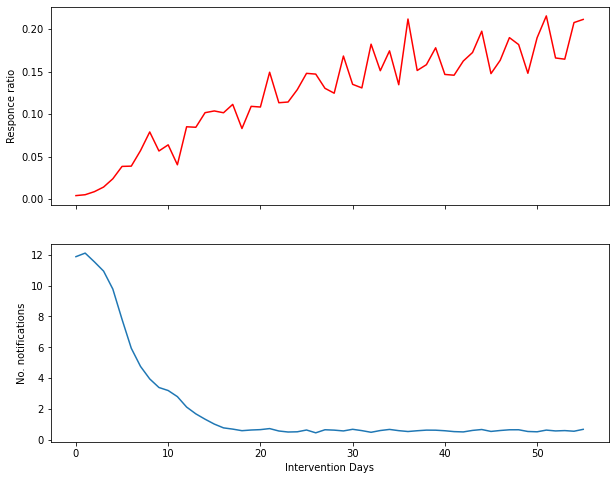

Patient 2
This figures include runs in which no prompt resulted in the activity being performed
256 out of 500 resulted in activity being performed 


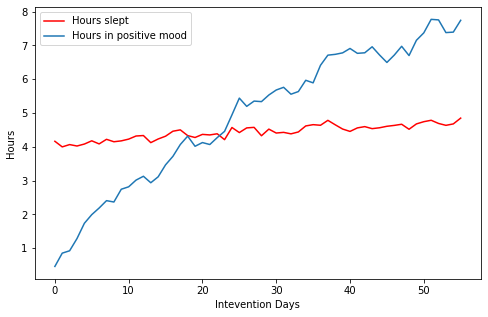

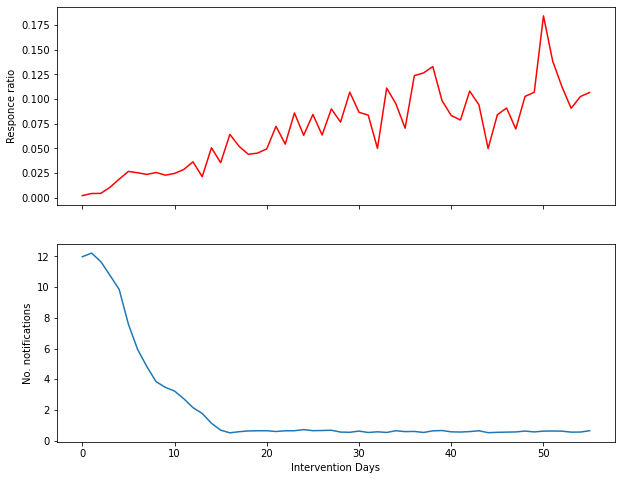

Patient 3
This figures include runs in which no prompt resulted in the activity being performed
283 out of 500 resulted in activity being performed 


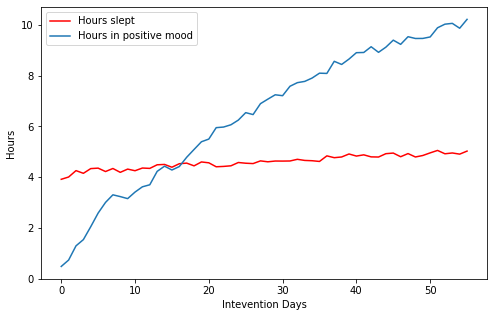

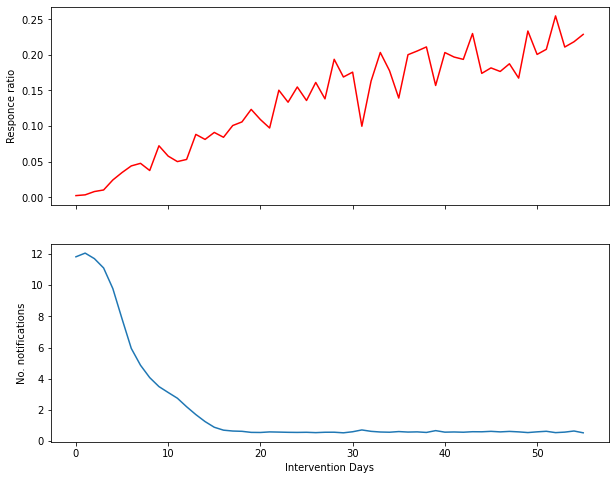

Patient 4
This figures include runs in which no prompt resulted in the activity being performed
310 out of 500 resulted in activity being performed 


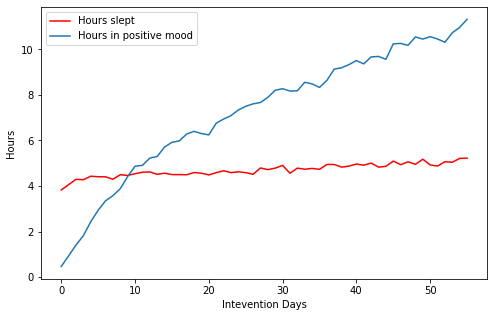

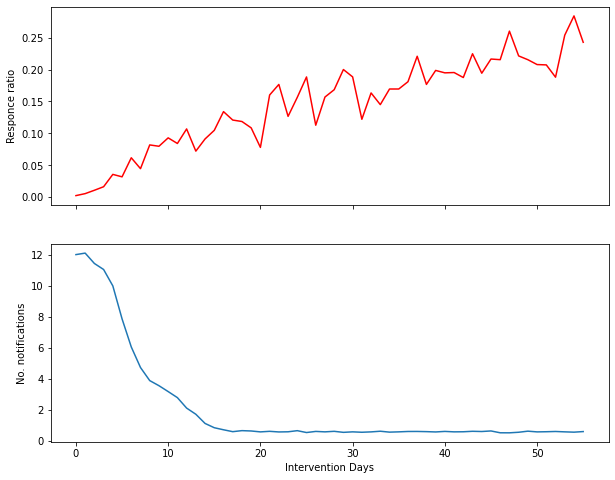

CPU times: user 4.14 s, sys: 466 ms, total: 4.61 s
Wall time: 1h 11min 18s


In [16]:
%%time 
for i, answers in enumerate(patients_answers):
    patient_id = i+1
    print(f"Patient {patient_id}")
    _ = run_experiment(dqn, runs, 'dqn', condition, answers, patient_id)

## Proximal Policy Optimisation

In [17]:
def ppo(env1):
    model = PPO("MlpPolicy", env1, verbose=0, n_steps=updated_every_day, batch_size=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

Patient 1
This figures include runs in which no prompt resulted in the activity being performed
298 out of 500 resulted in activity being performed 


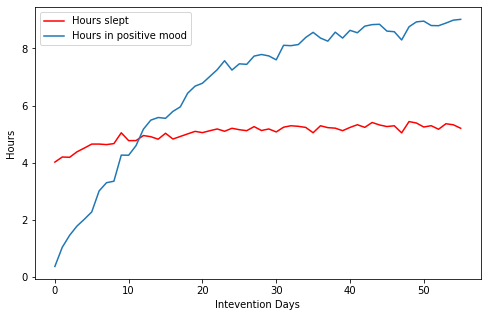

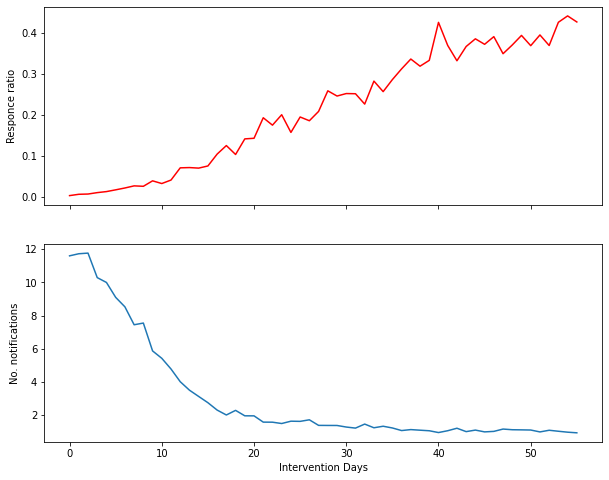

Patient 2
This figures include runs in which no prompt resulted in the activity being performed
279 out of 500 resulted in activity being performed 


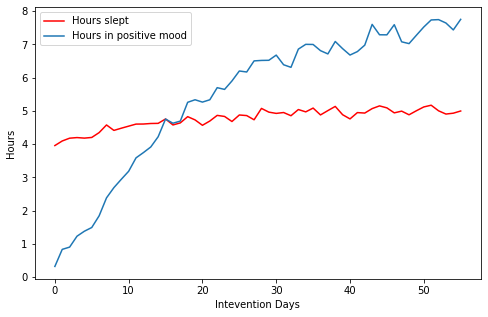

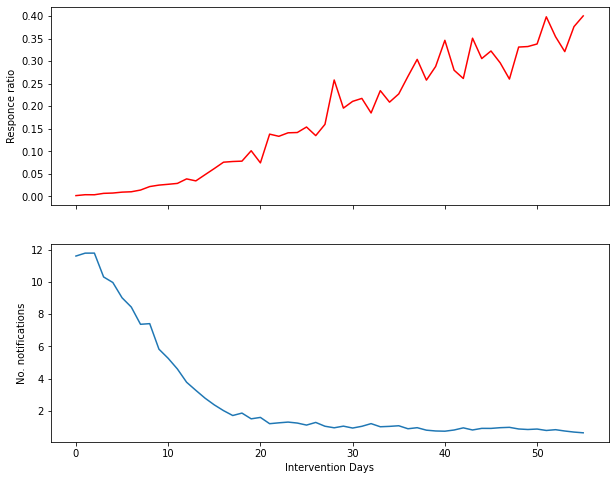

Patient 3
This figures include runs in which no prompt resulted in the activity being performed
274 out of 500 resulted in activity being performed 


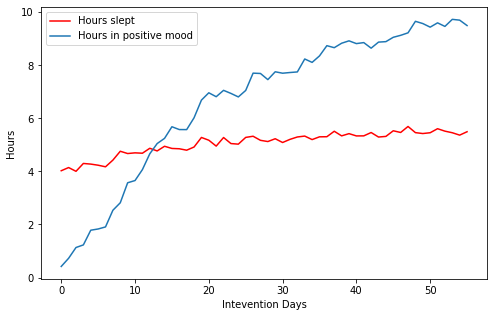

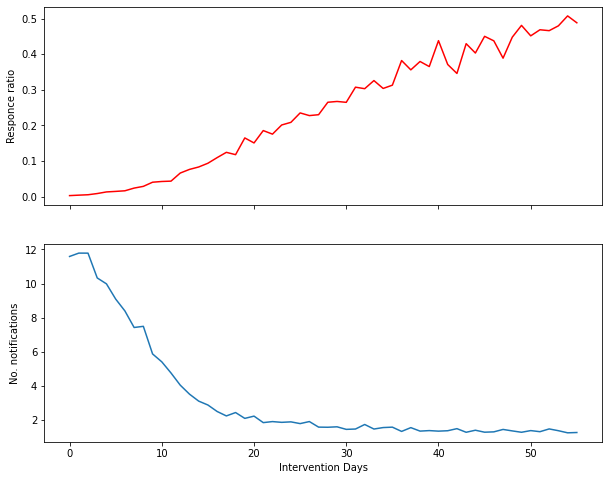

Patient 4
This figures include runs in which no prompt resulted in the activity being performed
287 out of 500 resulted in activity being performed 


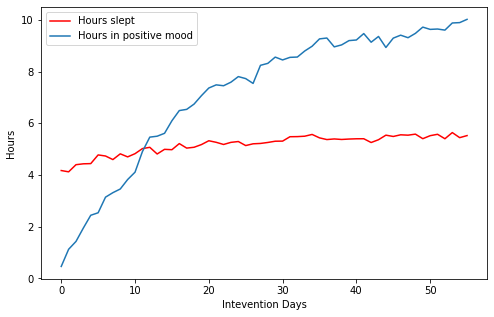

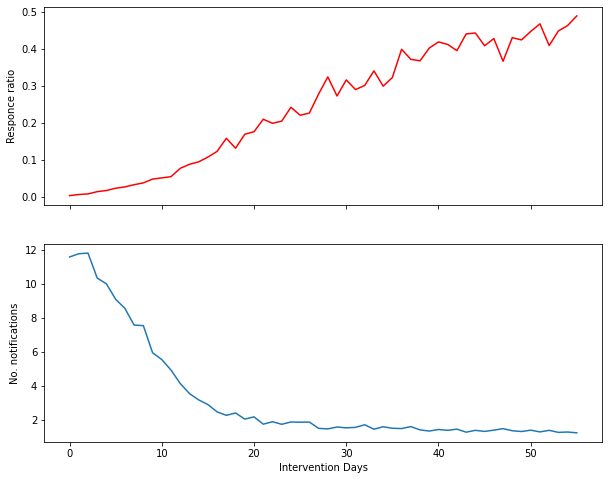

CPU times: user 4.57 s, sys: 475 ms, total: 5.04 s
Wall time: 1h 17min 20s


In [18]:
%%time 
for i, answers in enumerate(patients_answers):
    patient_id = i+1
    print(f"Patient {patient_id}")
    _ = run_experiment(ppo, runs, 'ppo', condition, answers, patient_id)

## Advantage Actor Critic

In [19]:
def a2c(env1):
    model = A2C("MlpPolicy", env1, verbose=0, n_steps=updated_every_day)
    model.learn(total_timesteps=eight_weeks)
    return env1

Patient 1
This figures include runs in which no prompt resulted in the activity being performed
365 out of 500 resulted in activity being performed 


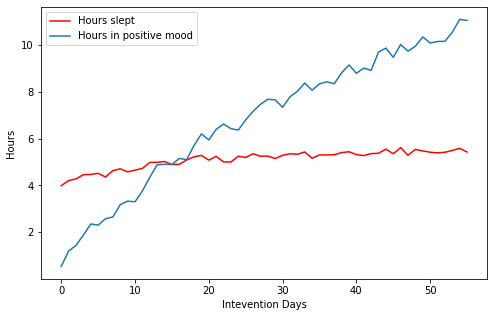

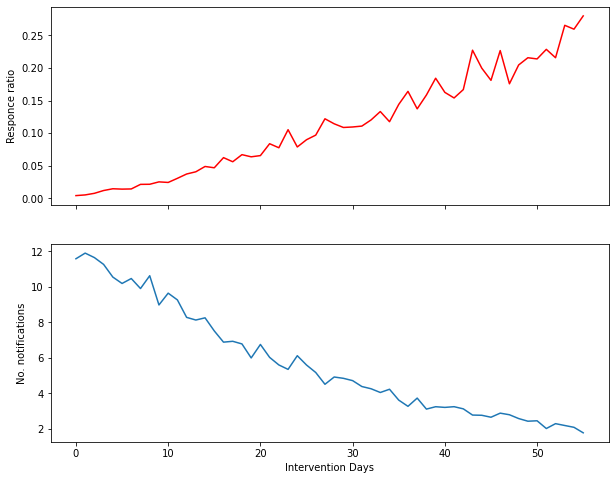

Patient 2
This figures include runs in which no prompt resulted in the activity being performed
361 out of 500 resulted in activity being performed 


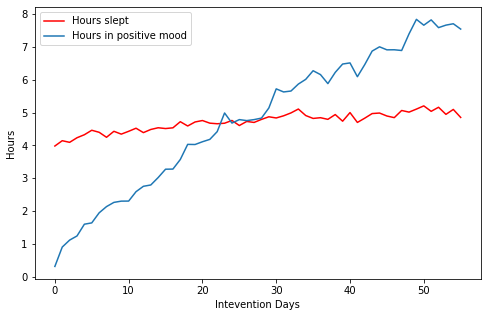

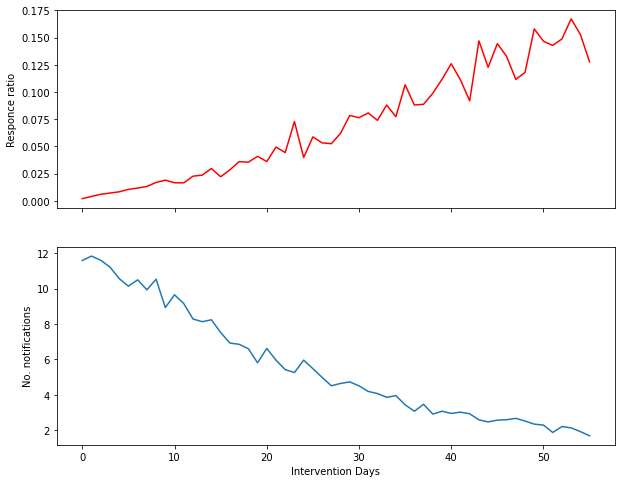

Patient 3
This figures include runs in which no prompt resulted in the activity being performed
354 out of 500 resulted in activity being performed 


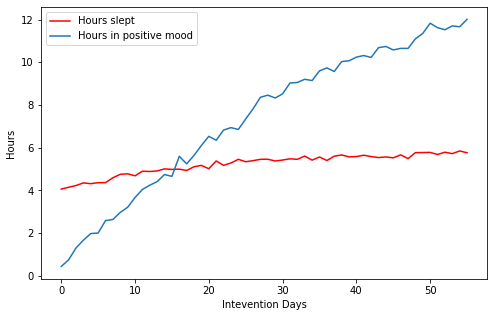

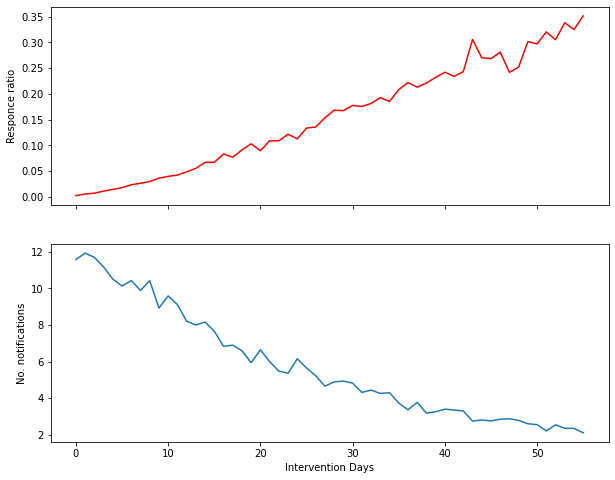

Patient 4
This figures include runs in which no prompt resulted in the activity being performed
357 out of 500 resulted in activity being performed 


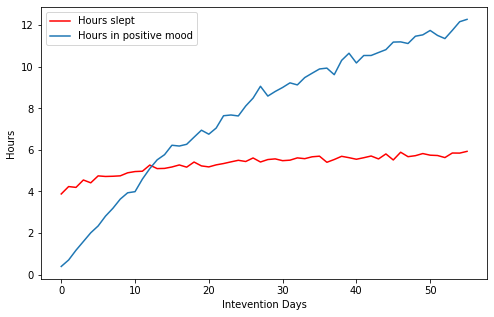

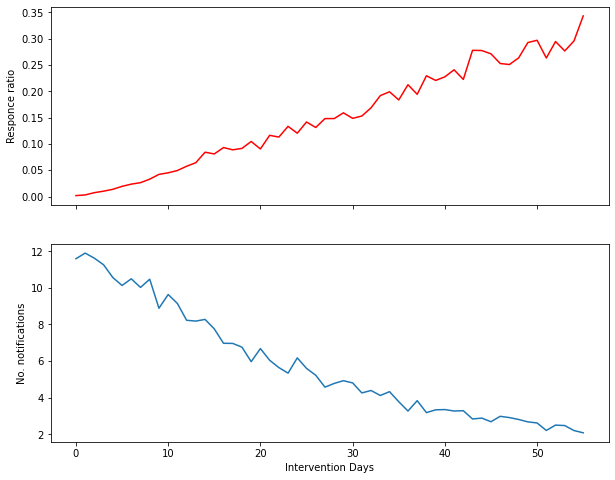

CPU times: user 5.64 s, sys: 606 ms, total: 6.25 s
Wall time: 31min 41s


In [20]:
%%time 
for i, answers in enumerate(patients_answers):
    patient_id = i+1
    print(f"Patient {patient_id}")
    _ = run_experiment(a2c, runs, 'a2c', condition, answers, patient_id)

## Plots

In [21]:
def get_rr_and_notification(name, patient_id, runs, condition):
    
    rr, noti = [],[]
    failed = 0
    for run in range(runs):
        df = pd.read_csv("{0}/patient{1}_{2}_{3}_run{4}.csv".format(results_directory, patient_id, condition, name, run))
        a_performed = sum(df['activity performed'].values)
        if a_performed > 0: # activity performed at least once in the course of the intervention
            rr.append(df.responce_ratio)
            noti.append(df.notifications)
        else:
            failed = failed +1 
    print(" For method {0} {1} out of {2} runs had no activity performed throught the full intervention.".format(name, failed, runs))
    return rr, noti, failed

In [22]:
method_names = ['random', 'rf_adaptive', 'dqn', 'ppo', 'a2c']
patients_data = [{name:{} for name in method_names} for _ in patients_answers]

In [23]:
for i in range(len(patients_answers)):
    patient_id = i+1
    print(f"Patient {patient_id}")
    for method_name in method_names:
        resp_ratios, notifs, failures = get_rr_and_notification(method_name, patient_id, runs, condition)
        patients_data[i][method_name]['resp_ratios'] = resp_ratios
        patients_data[i][method_name]['notifs'] = notifs
        patients_data[i][method_name]['failures'] = failures

Patient 1
 For method random 97 out of 500 runs had no activity performed throught the full intervention.
 For method rf_adaptive 269 out of 500 runs had no activity performed throught the full intervention.
 For method dqn 163 out of 500 runs had no activity performed throught the full intervention.
 For method ppo 202 out of 500 runs had no activity performed throught the full intervention.
 For method a2c 135 out of 500 runs had no activity performed throught the full intervention.
Patient 2
 For method random 112 out of 500 runs had no activity performed throught the full intervention.
 For method rf_adaptive 278 out of 500 runs had no activity performed throught the full intervention.
 For method dqn 244 out of 500 runs had no activity performed throught the full intervention.
 For method ppo 221 out of 500 runs had no activity performed throught the full intervention.
 For method a2c 139 out of 500 runs had no activity performed throught the full intervention.
Patient 3
 For meth

Patient 1:


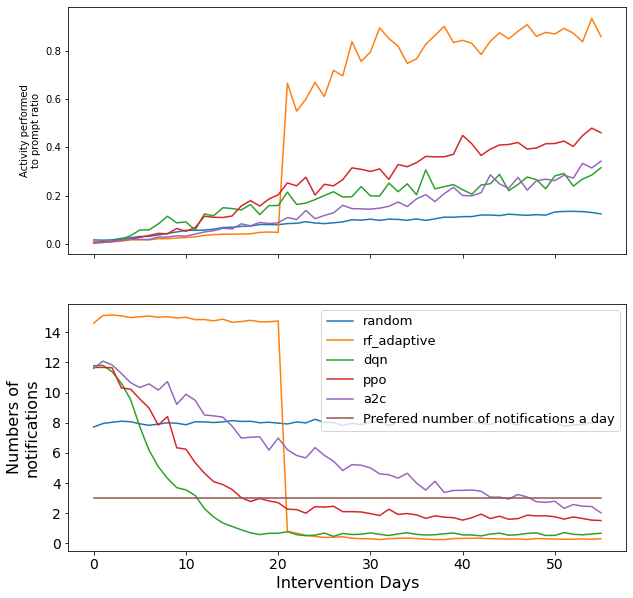

Patient 2:


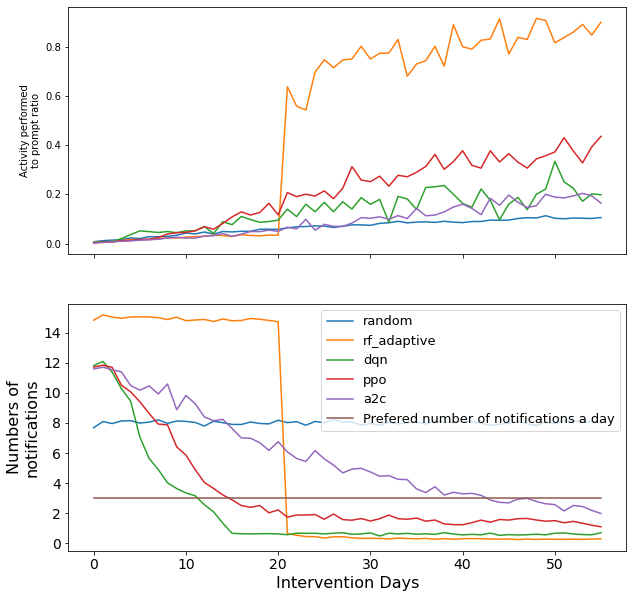

Patient 3:


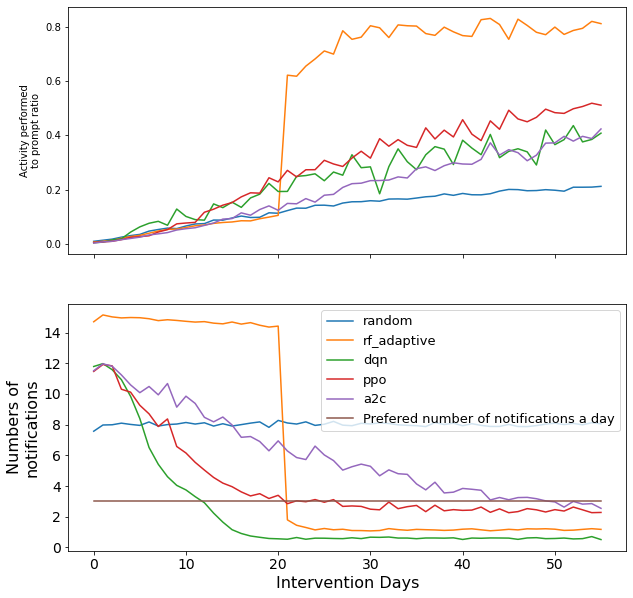

Patient 4:


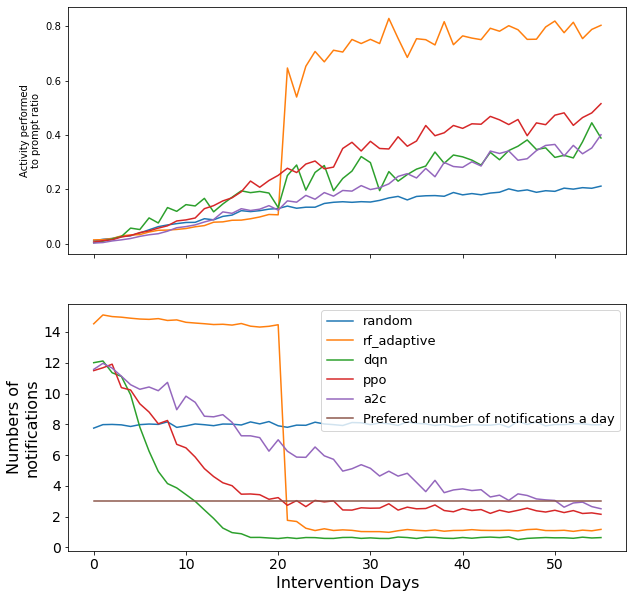

In [24]:
for i, patient_data in enumerate(patients_data):
    print(f"Patient {i+1}:")
    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10,10))
    for method_name, data in patient_data.items():
        ax1.plot(np.nanmean(data['resp_ratios'], axis=0), label=method_name)
    
    for method_name, data in patient_data.items():
        ax2.plot(np.nanmean(data['notifs'], axis=0), label=method_name)
    ax2.plot(np.ones(len(np.mean(patient_data['random']['notifs'], axis=0))) +2, label ='Prefered number of notifications a day')

    ax2.set_xlabel('Intervention Days', fontsize=16)
    ax2.set_ylabel('\n'.join(wrap('Numbers of notifications', 20)), fontsize=16)
    ax1.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)) )
    # ax3.set_ylabel( '\n'.join(wrap('Hours slept', 20)) )
    # plt.ylim(0, 0.95)
    ax2.legend(fontsize=10)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

Method: random


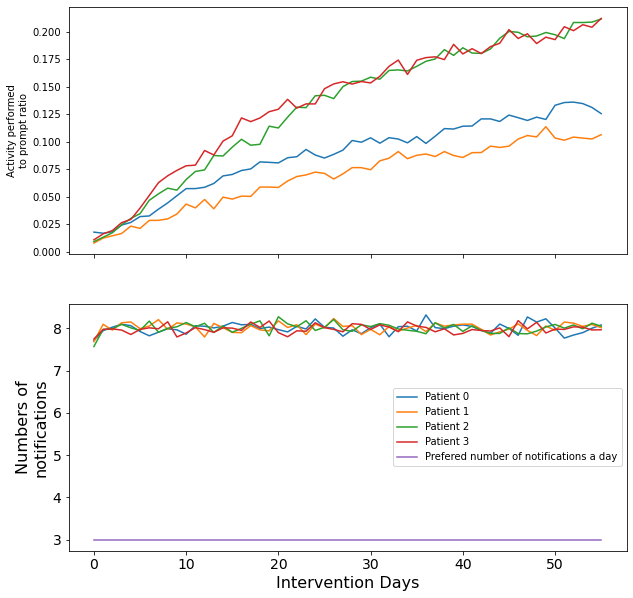

Method: rf_adaptive


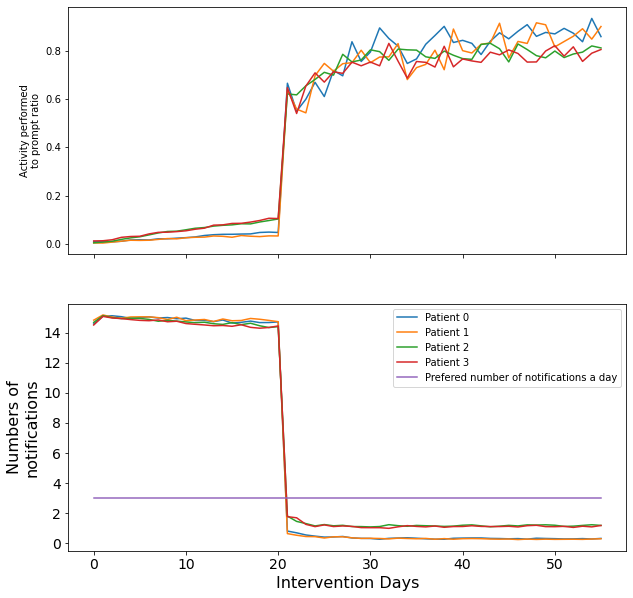

Method: dqn


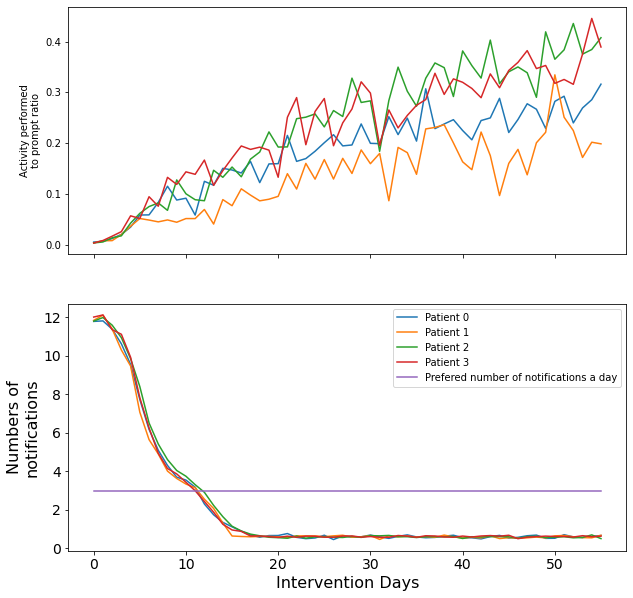

Method: ppo


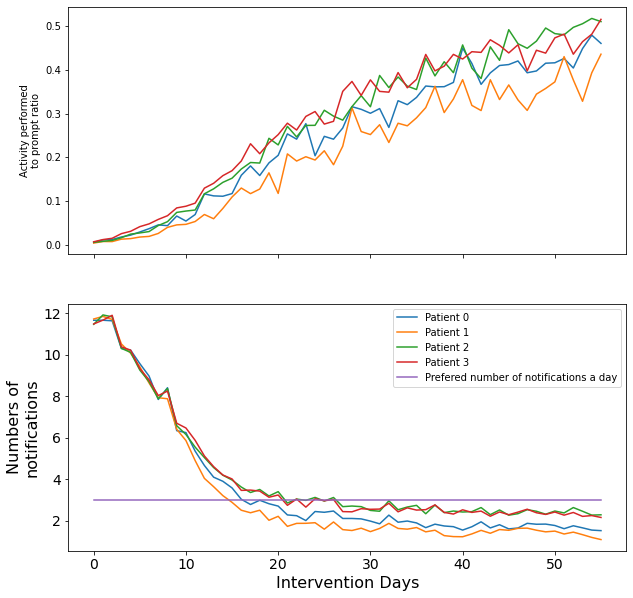

Method: a2c


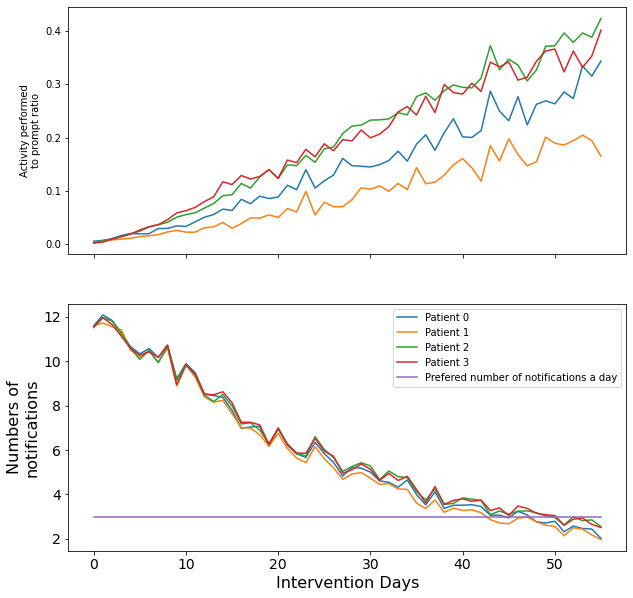

In [28]:
for method_name in method_names:
    print(f"Method: {method_name}")
    fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10,10))
    for i in range(len(patients_data)):
        ax1.plot(np.nanmean(patients_data[i][method_name]['resp_ratios'], axis=0), label=f"Patient {i}")
        
    for i in range(len(patients_data)):
        ax2.plot(np.nanmean(patients_data[i][method_name]['notifs'], axis=0), label=f"Patient {i}")
    ax2.plot(np.ones(len(np.mean(patients_data[0]['random']['notifs'], axis=0))) +2, label ='Prefered number of notifications a day')

    ax2.set_xlabel('Intervention Days', fontsize=16)
    ax2.set_ylabel('\n'.join(wrap('Numbers of notifications', 20)), fontsize=16)
    ax1.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)) )
    # ax3.set_ylabel( '\n'.join(wrap('Hours slept', 20)) )
    # plt.ylim(0, 0.95)
    ax2.legend(fontsize=10)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()